# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. 

This project will explore:
* EDA (Exploratory Data Analysis) on the data for the power outages
    * Map charts using the Folium package
    * Plt barcharts
* Hypothesis testing that concludes whether or not te mean duration of the outage has influence on whether or not the outage is classifiable as "major" (see above). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from datetime import datetime, timedelta

import folium


import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import pickle
import scipy.stats
from scipy.stats import ks_2samp

#filepath = os.path.join('data', 'outage.xlsx')
filepath = 'outage.xlsx'
skipped_rows = [0, 1, 2, 3, 4, 6]
outage = pd.read_excel(filepath, skiprows=skipped_rows)

In [3]:
level_of_measurements = {
"variables": "N",
"OBS": "O",
"YEAR": "N",
"MONTH": "O",
"U.S._STATE": "N",
"POSTAL.CODE": "N",
"NERC.REGION": "N",
"CLIMATE.REGION": "N",
"ANOMALY.LEVEL": "O",
"CLIMATE.CATEGORY": "N",
"OUTAGE.START.DATE": "Q",
"OUTAGE.START.TIME": "Q",
"OUTAGE.RESTORATION.DATE": "Q",
"OUTAGE.RESTORATION.TIME": "Q",
"CAUSE.CATEGORY": "N",
"CAUSE.CATEGORY.DETAIL": "N",
"HURRICANE.NAMES": "N",
"OUTAGE.DURATION": "Q",
"DEMAND.LOSS.MW": "Q",
"CUSTOMERS.AFFECTED": "Q",
"RES.PRICE": "Q",
"COM.PRICE": "Q",
"IND.PRICE": "Q",
"TOTAL.PRICE": "Q",
"RES.SALES": "Q",
"COM.SALES": "Q",
"IND.SALES": "Q",
"TOTAL.SALES": "Q",
"RES.PERCEN": "Q",
"COM.PERCEN": "Q",
"IND.PERCEN": "Q",
"RES.CUSTOMERS": "Q",
"COM.CUSTOMERS": "Q",
"IND.CUSTOMERS": "Q",
"TOTAL.CUSTOMERS": "Q",
"RES.CUST.PCT": "Q",
"COM.CUST.PCT": "Q",
"IND.CUST.PCT": "Q",
"PC.REALGSP.STATE": "Q",
"PC.REALGSP.USA": "Q",
"PC.REALGSP.REL": "Q",
"PC.REALGSP.CHANGE": "Q",
"UTIL.REALGSP": "Q",
"TOTAL.REALGSP": "Q",
"UTIL.CONTRI": "Q",
"PI.UTIL.OFUSA": "Q",
"POPULATION": "Q",
"POPPCT_URBAN": "Q",
"POPPCT_UC": "Q",
"POPDEN_URBAN": "Q",
"POPDEN_UC": "Q",
"POPDEN_RURAL": "Q",
"AREAPCT_URBAN": "Q",
"AREAPCT_UC": "Q",
"PCT_LAND": "Q",
"PCT_WATER_TOT": "Q",
"PCT_WATER_INLAND": "Q",
}

# Cleaning

This is just the data cleaning; Skip to the EDA section for the main content

* Dropping conceptually unnecessary columns
    * Variables column is empty; not needed, so drop it
    * OBS column is the index column; not needed, so drop it

In [4]:
outage = outage.drop(columns=["variables"])
outage = outage.drop(columns=["OBS"])
## dropping_columns, revisit!

* Dropping Time and Date columns
* Adding in Start and Restoration columns

In [5]:
start_date_col = "OUTAGE.START.DATE"
start_dates = pd.to_datetime(outage[start_date_col])

start_time_col = "OUTAGE.START.TIME"
start_times = pd.to_timedelta(outage[start_time_col].astype(str))
start = start_dates + start_times

restoration_date_col = "OUTAGE.RESTORATION.DATE"
restoration_dates = pd.to_datetime(outage[restoration_date_col])

restoration_time_col = "OUTAGE.RESTORATION.TIME"
restoration_times = pd.to_timedelta(outage[restoration_time_col].astype(str))
restoration = start_dates + start_times


outage["OUTAGE.RESTORATION"] = restoration

outage["OUTAGE.START"] = start

outage = outage.drop(columns=[start_date_col, start_time_col, restoration_date_col, restoration_time_col])
# dropping_columns revisit!

level_of_measurements["OUTAGE.START"] =  "Q",
level_of_measurements["OUTAGE.RESTORATION"] = "Q"
# adding_columns revisit!

* Some of the states have NERC REGIONS that shouldn't be covering them at all. 
    * For example, in Row 239, Texas is covered by FRCC, even though FRCC is exclusively Florida

In [6]:
PROPER_NERC_STATES = {
    
"NPCC": ["New York", "Connecticut", "Maine", "Massachusetts", 
         "New Hampshire", "Rhode Island","Vermont"],

"MRO": ["Arkansas", "Illinois", "Iowa", "Kansas", "Louisiana", 
        "Michigan", "Minnesota", "Missouri", "Montana", 
        "Nebraska", "New Mexico", "North Dakota", "Oklahoma", 
        "South Dakota", "Texas", "Wisconsin"],

"RFC": ["New Jersey", "Pennsylvania", "Maryland", "Delaware", "District of Columbia", 
        "West Virginia", "Ohio", "Indiana", "Michigan", "Wisconsin", 
        "Illinois", "Kentucky", "Tennessee","Virginia"],

"WECC": ['Texas', 'Washington', 'Arizona', 'Utah', 'Oregon', 'Montana',
       'California', 'Nebraska', 'Wyoming', 'New Mexico', 'Nevada',
       'Colorado', 'Idaho', 'South Dakota'],

"FRCC": ["Florida"],

"TRE": ["Texas"],
"ASCC": ["Alaska"],

"SERC": ['Missouri','Alabama','Tennessee','North Carolina',
         'South Carolina','Georgia','Mississippi','Iowa',
         'Illinois','Kentucky','Virginia','Oklahoma',
         'Arkansas','Louisiana','Texas','Florida'],
"SPP": ['Arkansas', 'Iowa', 'Kansas', 'Louisiana', 
        'Minnesota', 'Missouri', 'Montana', 'Nebraska', 
        'New Mexico', 'North Dakota', 'Oklahoma', 
        'South Dakota', 'Texas', 'Wyoming'],
}

* So we cross check to see if each state is in a nerc region that covers it.

In [7]:
def Verify_nerc(nerc_region, state):
    if nerc_region not in PROPER_NERC_STATES:
        return True
    else:
        return (state in PROPER_NERC_STATES[nerc_region])

In [8]:
verify_nerc_col = outage[["NERC.REGION","U.S._STATE"]].apply(lambda x: Verify_nerc(x["NERC.REGION"], x["U.S._STATE"]), axis=1)

* These are the rows with the inaccurate NERC regions

In [9]:
outage.loc[verify_nerc_col.values,:].head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.RESTORATION,OUTAGE.START
0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-01 17:00:00
1,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:38:00
2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-26 20:00:00
3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-19 04:30:00
4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-18 02:00:00


In [10]:
outage = outage.loc[verify_nerc_col.values,:]
# dropping_rows revisit!

* Drop the row where the nerc region is "FRCC, SERC" since we don't know which region to put it under
    * (Florida is covered by both SERC and FRCC)

In [11]:
outage = outage[~ outage["NERC.REGION"].isin(["FRCC, SERC"])]
# dropping_row, revisit!

* Drop Alaska since it only shows up once, and its not quite useful

In [12]:
outage = outage[~ outage["U.S._STATE"].isin(["Alaska"])]
# dropping_row, revisit!

* There are some instances where the CUSTOMERS.AFFECTED is bigger than the TOTAL.CUSTOMERS in the state.
* Whether or not this is a data-recording error, it will mess results, so we drop them

In [13]:
overrecorded_affected_customers = outage[(outage["CUSTOMERS.AFFECTED"] > outage["TOTAL.CUSTOMERS"])]

In [14]:
outage = outage[~(outage["CUSTOMERS.AFFECTED"] > outage["TOTAL.CUSTOMERS"])]
# dropping_row, revisit!

#### Regional Climate and Causes Cleaning

* Alaska and Hawaii don't have Climate Regions, set their climate regions with their names for now.

In [15]:
# Imputation
outage.loc[(outage["U.S._STATE"]).isin(["Alaska"]), ["CLIMATE.REGION"]] = "Alaska"
outage.loc[(outage["U.S._STATE"]).isin(["Hawaii"]), ["CLIMATE.REGION"]] = "Hawaii"
# setting_values, revisit!

#### regional electricity consumption Cleaning
* regional electricity consumption columns are the columns ['RES.PRICE', 'COM.PRICE',
       'IND.PRICE', 'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES',
       'TOTAL.SALES', 'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN',
       'RES.CUSTOMERS', 'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS',
       'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT']
* I don't have background knowledge on US Electricity consumption to see if the columns' data collection is legitimate.
* But I will still check if the columns' math holds up.

In [16]:
elec_consump_price_raw_columns = ['RES.PRICE', 'COM.PRICE','IND.PRICE', 'TOTAL.PRICE']
elec_consump_sales_raw_columns = ['RES.SALES', 'COM.SALES', 'IND.SALES','TOTAL.SALES']
elec_consump_sales_perc_columns = ['RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN']
elec_consump_custs_raw_columns = ['RES.CUSTOMERS', 'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS']
elec_consump_custs_perc_columns = ['RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT']

In [17]:
def verify_perc(df, raw_column_names, perc_column_names):
    total = df[raw_column_names[-1]]#.values
    props = df[raw_column_names[:-1]].div(total, axis=0) * 100
    accuracy = np.abs(props.to_numpy() - df[perc_column_names].to_numpy())
    accuracy = accuracy[~np.isnan(accuracy)] # remove nans
    return accuracy.mean()

In [18]:
verify_perc(outage, elec_consump_sales_raw_columns, elec_consump_sales_perc_columns)

2.383046226185722e-14

In [19]:
verify_perc(outage, elec_consump_custs_raw_columns, elec_consump_custs_perc_columns)

0.0

#### Land Area Cleaning
* Land Area columns are the columns ['PCT_LAND','PCT_WATER_TOT', 'PCT_WATER_INLAND', 'AREAPCT_UC', 'AREAPCT_URBAN']
* All columns seem legitimate and clean (of data errors), by general background knowledge of US states
* ['PCT_LAND','PCT_WATER_TOT', 'PCT_WATER_INLAND'] don't seem useful/will be dropped
* Not sure what to do with 'AREAPCT_UC', definition doesn't seem useful, will be dropped
* 'AREAPCT_URBAN' seems very useful, will be kept.

In [20]:
outage.groupby(["U.S._STATE"])["PCT_WATER_TOT"].mean().sort_values(ascending=False).reset_index().head()
# predictably, Michigan

,U.S._STATE,PCT_WATER_TOT
0,Michigan,41.540005
1,Hawaii,41.245884
2,Massachusetts,26.094372
3,Maryland,21.755602
4,Delaware,21.695460


In [21]:
outage.groupby(["U.S._STATE"])["PCT_LAND"].mean().sort_values(ascending=False).reset_index().head()
# Unpredictably, not Texas or Alaska!

,U.S._STATE,PCT_LAND
0,New Mexico,99.759849
1,Arizona,99.652601
2,Colorado,99.565777
3,Kansas,99.369212
4,Nebraska,99.322542


* ['AREAPCT_URBAN', 'AREAPCT_UC'] seem useful!

In [22]:
outage.groupby(["U.S._STATE"])["AREAPCT_URBAN"].mean().sort_values(ascending=False).reset_index().head()

,U.S._STATE,AREAPCT_URBAN
0,District of Columbia,100.00
1,New Jersey,39.70
2,Massachusetts,38.29
3,Connecticut,37.72
4,Delaware,20.88


In [23]:
outage.groupby(["U.S._STATE"])["AREAPCT_URBAN"].mean().sort_values(ascending=False).reset_index().tail()

,U.S._STATE,AREAPCT_URBAN
44,Idaho,0.60
45,South Dakota,0.30
46,North Dakota,0.27
47,Montana,0.20
48,Wyoming,0.20


In [24]:
# "AREAPCT_URBAN" seems legitimate and makes sense, the eastern seaboard states (like Delaware) are all urbanized and really small, so urban area percentage must be high.
# Whereas mountain states like South Dakota are sparsely urbanized, 

In [25]:
outage = outage.drop(columns=['PCT_LAND','PCT_WATER_TOT', 'PCT_WATER_INLAND','AREAPCT_UC'])
## dropping_columns, revisit!

#### population cleaning

In [26]:
pop_column_names =  ['POPULATION',
       'POPPCT_URBAN', 'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC',
       'POPDEN_RURAL']

In [27]:
outage.groupby(["U.S._STATE"])["POPDEN_RURAL"].mean().sort_values(ascending=False).reset_index().head()

,U.S._STATE,POPDEN_RURAL
0,Connecticut,142.3
1,Massachusetts,109.2
2,New Jersey,105.5
3,Delaware,97.3
4,Maryland,96.0


In [28]:
# again, I'm not sure what UC (Urban cluster) is or how to use it in data, so we drop it.
outage = outage.drop(columns=['POPPCT_UC', 'POPDEN_UC'])
## dropping_columns, revisit!

In [29]:
DemandLossMWThresholdBool = outage["DEMAND.LOSS.MW"] >= 300
CustomersAffectedThresholdBool = (outage["CUSTOMERS.AFFECTED"] >= 50_000)
DemandLossMWNotnullBool = (outage["DEMAND.LOSS.MW"].notnull())
CustomersAffectedNotnullBool = (outage["CUSTOMERS.AFFECTED"].notnull())


def isMajor(demandlossmw, customersaffected):
    if np.isnan(demandlossmw) or np.isnan(customersaffected):
        return np.nan
    else:
        return (demandlossmw >= 300) or (customersaffected >=50_000)

#outage["IS.MAJOR"] = outage[["DEMAND.LOSS.MW","CUSTOMERS.AFFECTED"]].apply(lambda x: isMajor(x["DEMAND.LOSS.MW"], 
#                                                                                             x["CUSTOMERS.AFFECTED"]))
outage["IS.MAJOR"] = np.vectorize(isMajor)(outage["DEMAND.LOSS.MW"],outage["CUSTOMERS.AFFECTED"])

level_of_measurements["IS.MAJOR"] = "Q"


# EDA

### Looking at Maps:

* Mapping States
    * Seeing Mean Outage Duration in minutes
    * Seeing Percentage of Customers affected 

In [30]:
#import folium
map0 = folium.Map(location=[48, -102], zoom_start=3)
my_USA_map_json = 'us-states.json'
nerc_json = "NERC_Regions_Subregions.json"

In [31]:
outage_grouped = outage.groupby(['POSTAL.CODE'],as_index=False).mean()[['POSTAL.CODE', 'OUTAGE.DURATION']]
# Use state abbreviations (POSTAL.CODE), not the state names themselves

In [32]:
map0.choropleth(geo_data=my_USA_map_json, data=outage_grouped, #'*/data/temp_outage.csv',
             columns=['POSTAL.CODE', 'OUTAGE.DURATION'],
             key_on='feature.id',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Mean Outage Duration (minutes)')
map0

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning



* Susceptibility to outages 
    * Explanations from climates 
        - e.g. maybe hurricane and tornado states have longer outages than states without them
    * State of Infrastructure itself
        - e.g. Underpopulated states might have longer outages than more urbanized states where infrastructure is more  developed)
    * Or just abnormal, incidental causes:
        - e.g. sabotage
* Biases from data collection itself:
    * For example, maybe the mountain-west states do experience long outages, but it goes underreported because sparsely populated

In [33]:
# To avoid problems about underreporting, we'll avoid trying to measure severity of ooutages per state b the number of their occurences.

* Ranking by Mean Percentage of Affected Customers by State

In [34]:
outage_temp = outage.copy()
outage_temp["PERC.CUSTOMERS.AFFECTED"] = outage_temp["CUSTOMERS.AFFECTED"]/outage_temp["TOTAL.CUSTOMERS"]
outage_temp1 = outage_temp[["POSTAL.CODE","PERC.CUSTOMERS.AFFECTED"]]
outage_grouped1= outage_temp1.groupby(["POSTAL.CODE"], as_index=False).mean()
map1 = folium.Map(location=[48, -102], zoom_start=3)

In [35]:
MAX_SCALER_FOR_VISIBILITY = 100 / outage_grouped1["PERC.CUSTOMERS.AFFECTED"].max()
outage_grouped1["PERC.CUSTOMERS.AFFECTED"] *= MAX_SCALER_FOR_VISIBILITY

* I multiplied the column by a "max scaler" so that the maximum value is 100, making the otherwise skewed distribution more visible in the map

In [36]:
map1.choropleth(geo_data=my_USA_map_json, data=outage_grouped1, #'*/data/temp_outage.csv',
             columns=['POSTAL.CODE', "PERC.CUSTOMERS.AFFECTED"],
             key_on='feature.id',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='PERC.CUSTOMERS.AFFECTED')
map1

#### When do outages spike by month for each climate region?

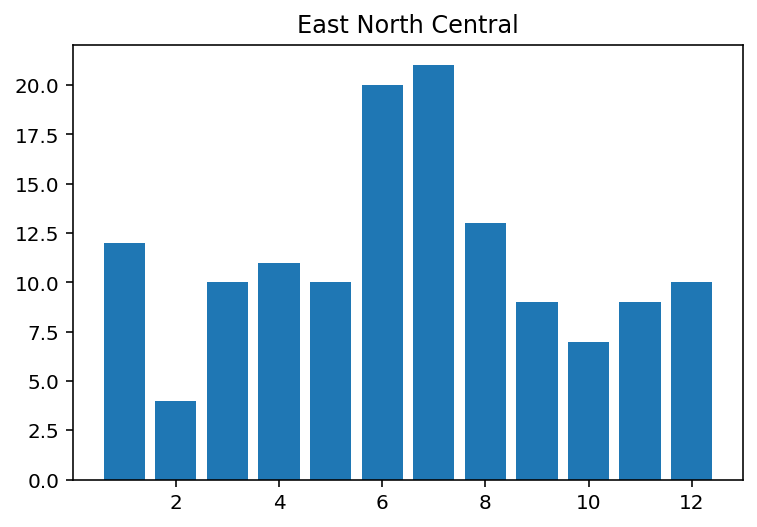

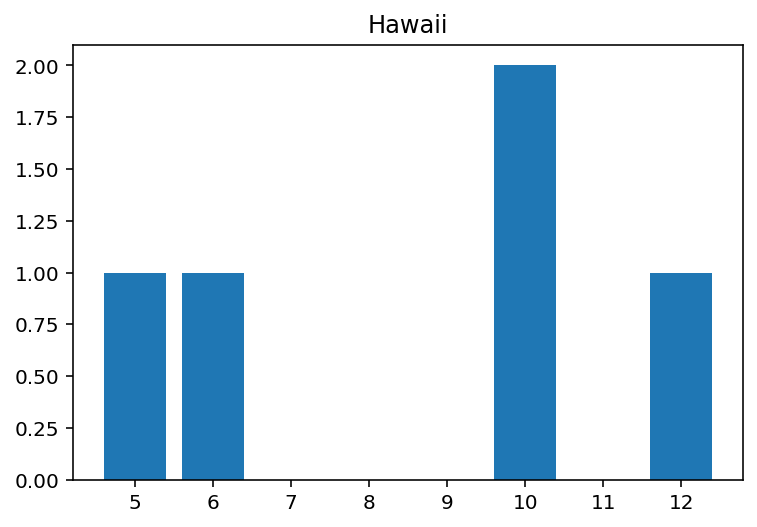

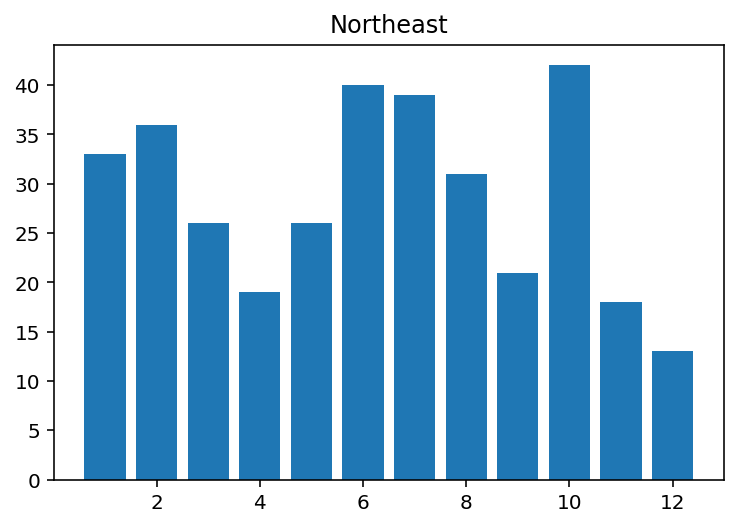

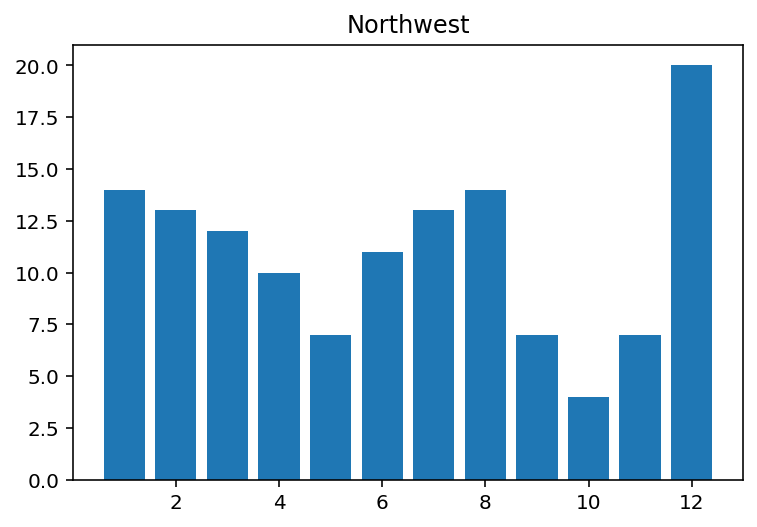

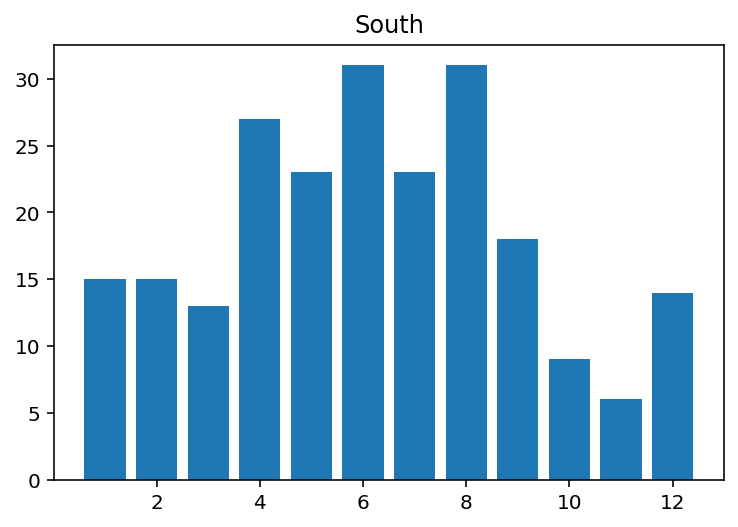

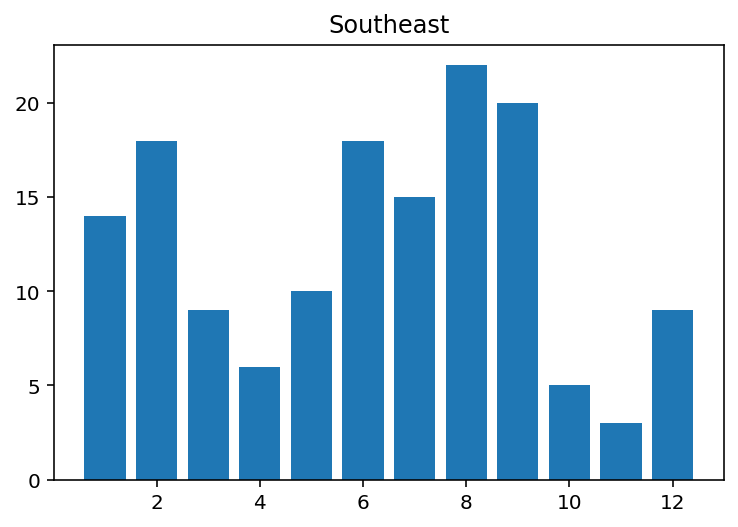

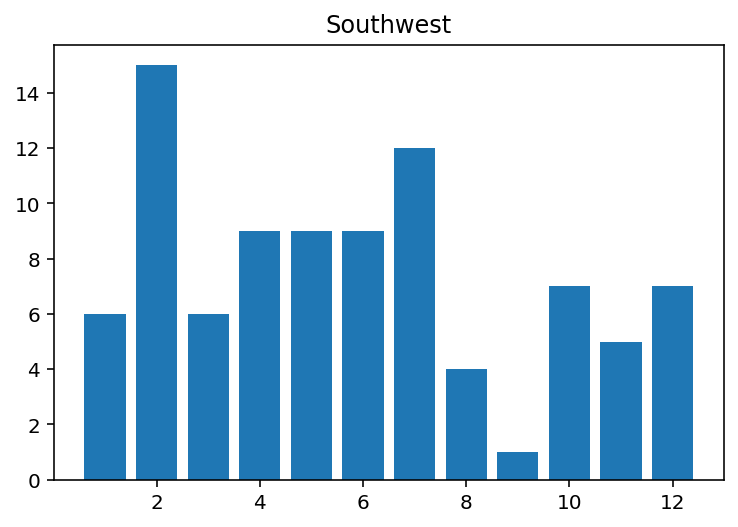

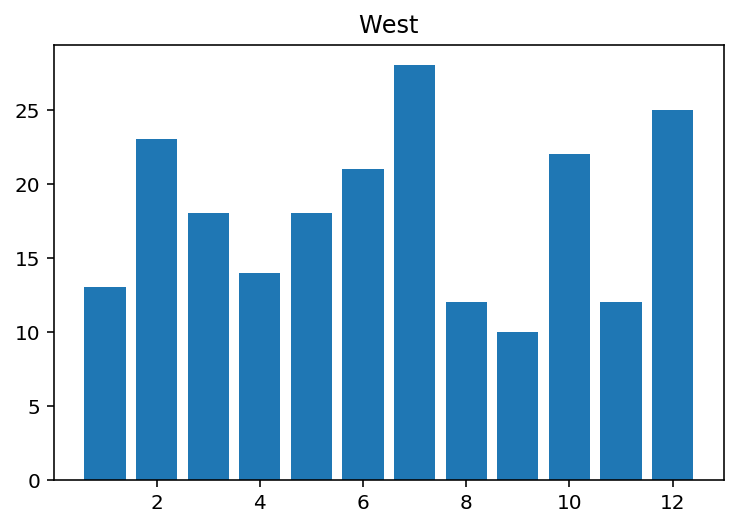

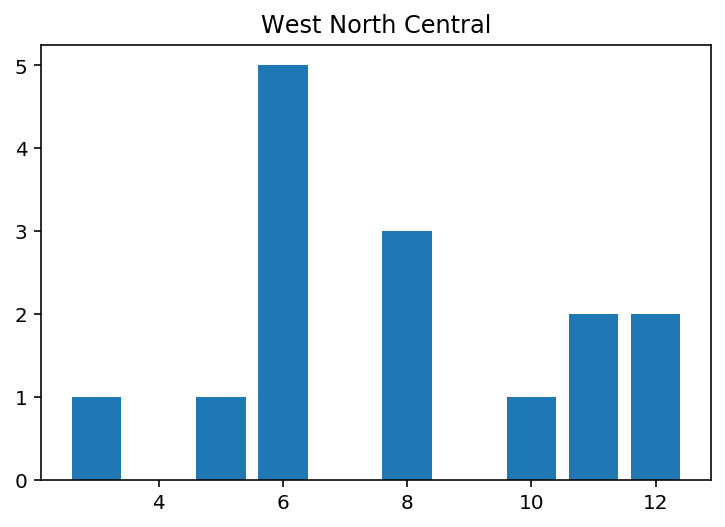

In [37]:
climate_regions_by_month = outage.groupby(["CLIMATE.REGION"])["MONTH"].agg(list)
climate_regions_by_month

for i in range(1, climate_regions_by_month.shape[0]):
    array = climate_regions_by_month[i]
    series = pd.Series(array).value_counts()
    values = series.values
    if np.isnan(values).all():
        continue
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(series.index, series.values)
    ax.set_title(climate_regions_by_month.index[i])

### Hypothesis Test

* Now we focus on the main question of major power outages, in terms of the severity columns made before.

* We would like to see if major Outages have a longer mean OUTAGE.DURATION compared to the mean OUTAGE.DURATIONs of non-major Outages
* Will use a significance level of 0.05.
* Null Hypothesis: the mean of the OUTAGE.DURATION of the major Outages isn't greater than the mean of the OUTAGE.DURATION of the non major Outages.
* Alternative Hypothesis: the mean of the OUTAGE.DURATION of the major Outages is less the mean of the OUTAGE.DURATION of the non major Outages. 

In [38]:
varb1 = "OUTAGE.DURATION"
varb2 = "IS.MAJOR"

hypotest_cols = [varb1,varb2]
hypotest_df = outage[hypotest_cols]

hypotest_df = hypotest_df.dropna()

N = 10000
samp_size = 50
test_stats = []
obs_test_stat = hypotest_df[hypotest_df[varb2] == True].dropna()[varb1].mean()
for i in range(N):
    nonmajor_outage_durations = hypotest_df[hypotest_df[varb2] == False][varb1].values
    samp = np.random.choice(nonmajor_outage_durations, samp_size, replace=True)
    samp_mean = samp.mean()
    test_stats.append(samp_mean)

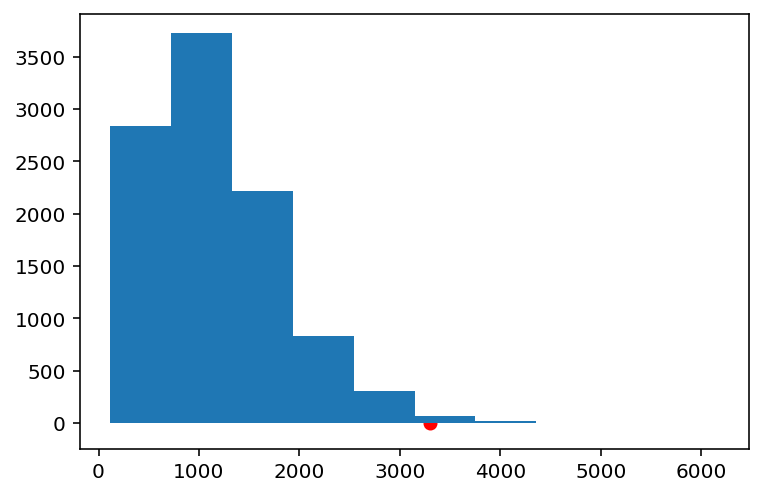

In [39]:
plt.hist(test_stats)
plt.scatter(obs_test_stat, 0,color="red")

In [40]:
p_value = (test_stats > obs_test_stat).mean()
print(p_value)

0.0066


* This p_value is 0.0068, which is less than 0.05, the significance level.
* We reject the Null Hypothesis, and have not found enough evidence that would apparently show that the mean of the OUTAGE.DURATION of the major Outages isn't greater than the mean of the OUTAGE.DURATION of the non major Outages.
* for now, it favors the alternate hypothesis, and among the data collected, the mean of the OUTAGE.DURATION of the major Outages seems to be greater than the mean of the OUTAGE.DURATION of the non major Outages.